In [17]:
import random
from pathlib import Path

import numpy as np
import torch
from tsai.all import (TCN, ShowGraph, TSRegression, TSStandardize, get_splits,
                      get_ts_dls, mae, mape, rmse, ts_learner)

from forecast import load_data

seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [18]:
(sc, train_size, test_size, data, dataX, dataY, trainX, trainY, testX, testY) = load_data(
    base_path=Path('./data/dfyj/key2_20240618_20240718'),
    ip='8.27.105.214'
)

dataX = dataX.reshape(dataX.shape[0], 1, dataX.shape[1])
trainX = trainX.reshape(trainX.shape[0], 1, trainX.shape[1])
testX = testX.reshape(testX.shape[0], 1, testX.shape[1])

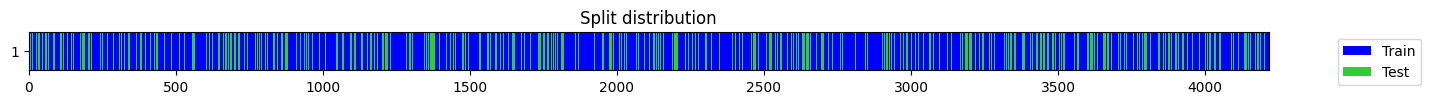

In [6]:
splits = get_splits(dataY, valid_size=.3, stratify=True,
                    random_state=23, shuffle=True)
tfms = [None, [TSRegression()]]
batch_tfms = TSStandardize(by_sample=True, by_var=True)
dls = get_ts_dls(dataX, dataY, splits=splits, tfms=tfms,
                 batch_tfms=batch_tfms, bs=128, device=device)

SuggestedLRs(valley=0.0012022644514217973)

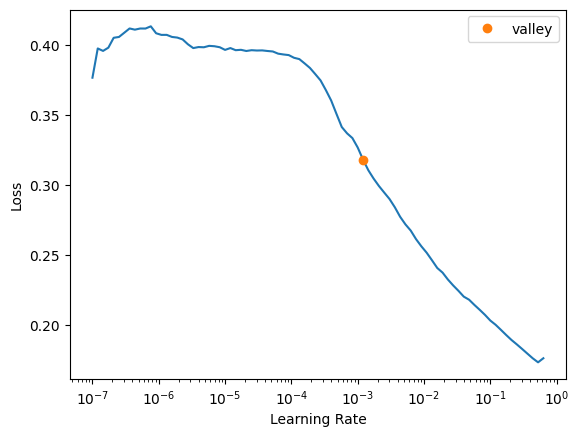

In [8]:
learn = ts_learner(dls, TCN, metrics=[
                   mae, rmse, mape], cbs=ShowGraph())
learn.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,mape,time
0,0.510282,0.488912,0.664254,0.699222,0.819008,00:02
1,0.469586,0.386614,0.582188,0.621783,0.702640,00:02
2,0.347251,0.049694,0.162026,0.222922,0.311697,00:02
3,0.225079,0.064209,0.247303,0.253394,0.346673,00:02
4,0.153889,0.052171,0.217822,0.228409,0.333492,00:02
5,0.112239,0.047065,0.179536,0.216944,0.317713,00:02
6,0.087275,0.046876,0.194335,0.216509,0.321402,00:02
7,0.071472,0.043351,0.168915,0.208208,0.302119,00:02
8,0.058902,0.026474,0.136783,0.162709,0.233426,00:02
9,0.042667,0.011150,0.082013,0.105592,0.105457,00:02


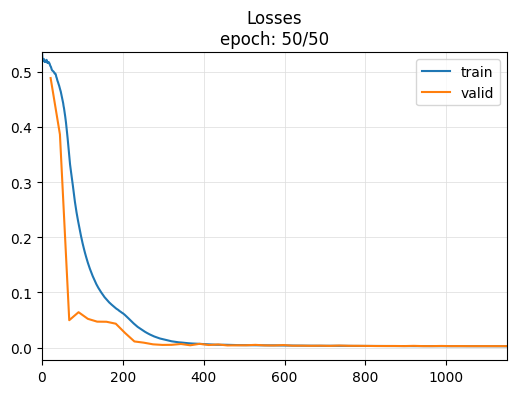

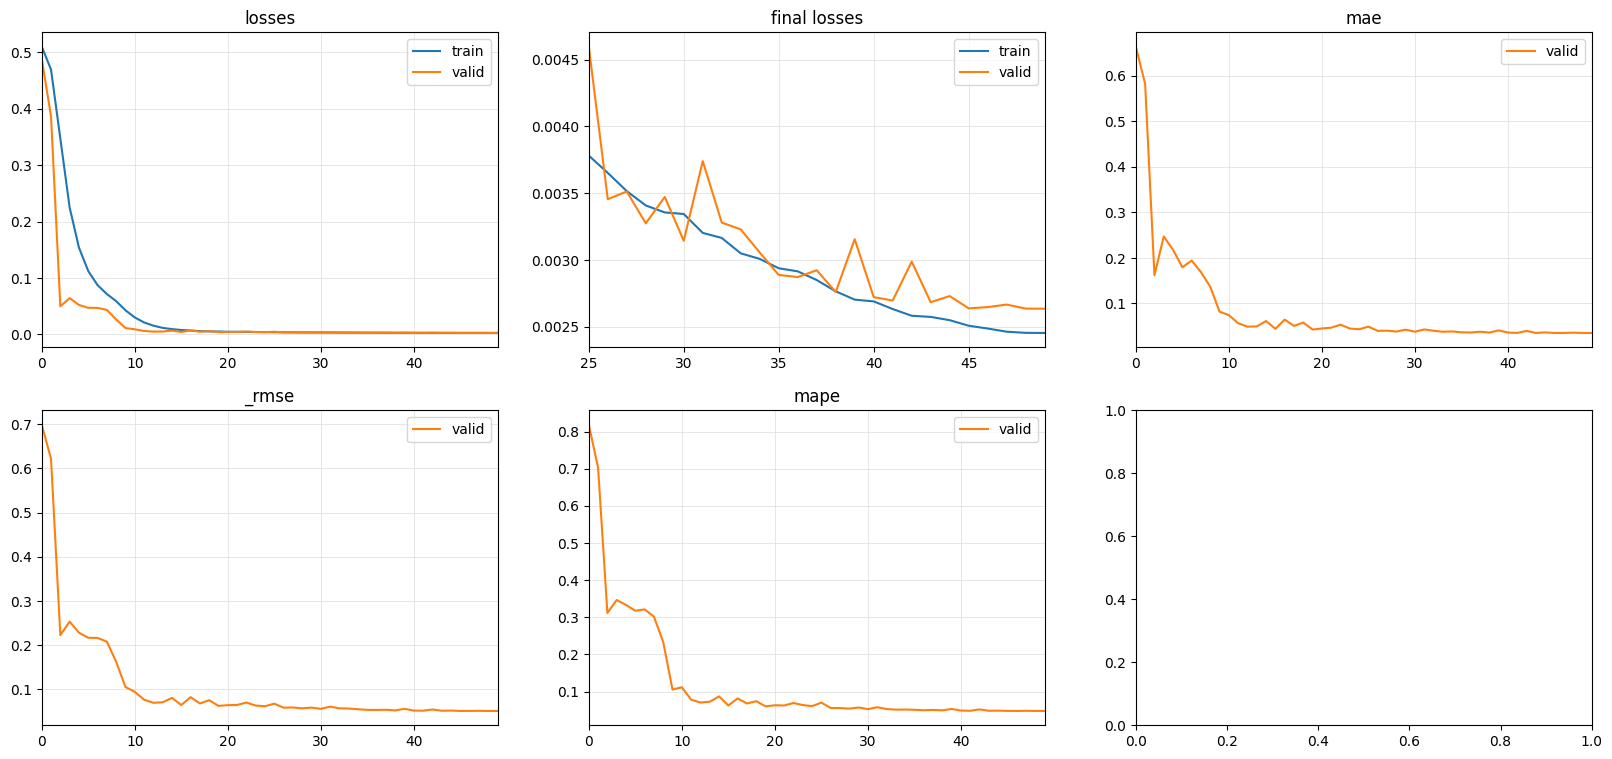

In [9]:
learn = ts_learner(dls, TCN, metrics=[
                   mae, rmse, mape], cbs=ShowGraph())
learn.fit_one_cycle(50, 1e-3)

In [34]:
data_alt = load_data(
    Path('./data/dfyj/key1_20240618_20240718'),
    "8.27.105.214"
)

testX_alt = data_alt[8].reshape(data_alt[8].shape[0], 1, data_alt[8].shape[1])
testY_alt = data_alt[9]

test_probas, test_targets, test_preds, test_losses = learn.get_X_preds(
    testX_alt, testY_alt, with_decoded=True, with_loss=True)

print(f"MAE: {mae(torch.tensor(test_preds), testY_alt)}")
print(f"RMSE: {rmse(torch.tensor(test_preds), testY_alt)}")
print(f"MAPE: {mape(torch.tensor(test_preds), testY_alt)}")

MAE: TensorBase(0.0408)
RMSE: TensorBase(0.0591)
MAPE: TensorBase(0.0525)
